In [1]:
## Import needed libraries
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import pylab   as plt

In [2]:
# hSBM specific libraries
from sbmtm import sbmtm
import graph_tool.all as gt

In [3]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [4]:
file = open('hSBM_simple_model.pickle', 'rb')
model = pickle.load(file)

In [5]:
# The hierarchical levels themselves are represented by individual BlockState() instances
levels = model.state.get_levels()
for s in levels:
    print(s)
    if s.get_N() == 1:
        break

<BlockState object with 38423 blocks (2 nonempty), degree-corrected, for graph <Graph object, undirected, with 38423 vertices and 46181 edges, 2 internal vertex properties, at 0x7fefec1c18e0>, at 0x7fefccd8bca0>
<BlockState object with 2 blocks (1 nonempty), for graph <Graph object, undirected, with 38423 vertices and 1 edge, at 0x7fefc3f7d580>, at 0x7fefc3f7ddf0>


In [6]:
nest_state = model.state
lstate = nest_state.get_levels()[0]
adj_matrix = gt.adjacency(g=lstate.get_bg(),weight=lstate.get_ers()).T
synth_graph = gt.generate_sbm(b=lstate.b.a, probs=adj_matrix, 
                            out_degs=lstate.g.degree_property_map("total").a,
                            in_degs=lstate.g.degree_property_map("total").a,
                            directed=False)
synth_nest_state = model.state.copy(g=synth_graph)

In [7]:
synth_file = open('synth_hSBM_simple_model.pickle', 'rb')
synth_model = pickle.load(synth_file)

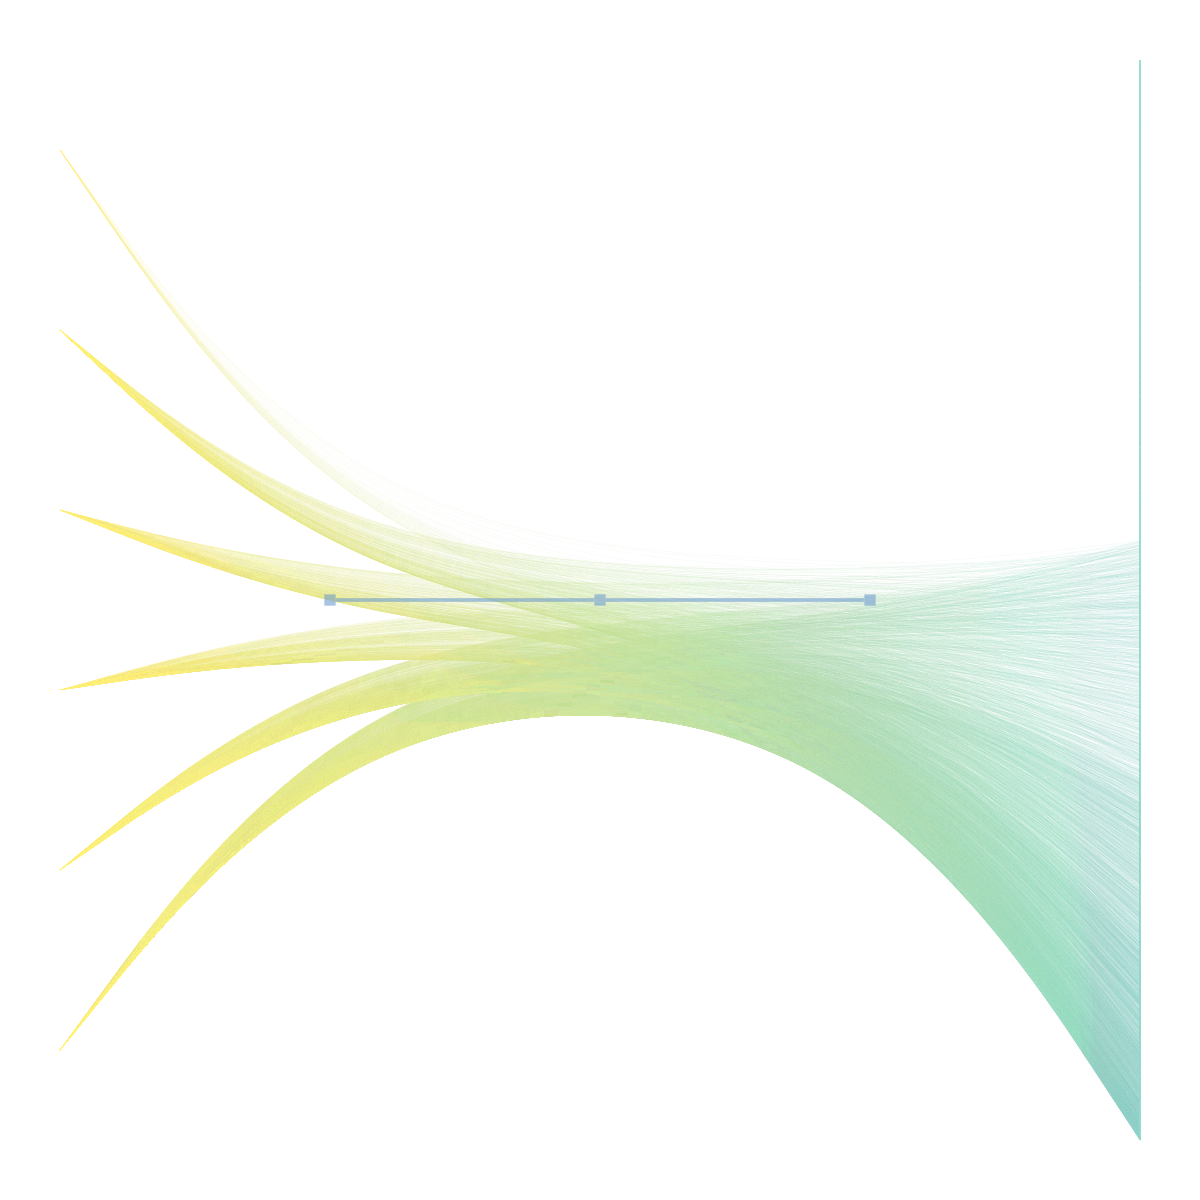

(<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7eff404ba6a0, at 0x7eff404babb0>,
 <GraphView object, directed, with 38426 vertices and 38425 edges, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x7eff404bad60, at 0x7eff407675e0>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x7eff404bad60, at 0x7eff407678b0>, False), at 0x7eff404bad60>,
 <VertexPropertyMap object with value type 'vector<double>', for Graph 0x7eff404bad60, at 0x7eff4075da00>)

In [8]:
synth_model.draw(subsample_edges=6000,layout='bipartite',bip_aspect=1, hvertex_size=8, hedge_pen_width=1.9, output_size=(600, 600))

In [9]:
def index_array(which_model,clabel):
    array = [i for i in range(len(which_model.get_clabel(l=0).a)) if which_model.get_clabel(l=0).a[i] == clabel]
    return array

In [10]:
words_index = index_array(which_model=synth_model, clabel=1)
documents_index = index_array(which_model=synth_model, clabel=0)

synth_df = pd.DataFrame(data=0, index=documents_index, columns=words_index)

for document in documents_index:
    neighbors = nest_state.g.get_all_neighbors(document)
    if neighbors.size == 0:
        continue
    else:
        for col in synth_df.columns:
            if col in neighbors:
                synth_df[col][document] = 1

synth_df

,38417,38418,38419,38420,38421,38422
0,1,1,0,0,0,0
1,0,1,1,0,0,0
2,0,0,0,1,0,0
3,0,1,0,0,0,0
4,0,1,0,1,0,0
...,...,...,...,...,...,...
38412,0,0,0,0,0,0
38413,0,0,0,1,1,0
38414,0,0,0,0,1,0
38415,0,1,0,1,0,0


In [11]:
state = model.state
state_0 = state.get_levels()[0]
matrix = gt.adjacency(g=state_0.get_bg(),weight=state_0.get_ers()).T
graph = gt.generate_sbm(b=state_0.b.a, probs=matrix, 
                            out_degs=state_0.g.degree_property_map("total").a,
                            in_degs=state_0.g.degree_property_map("total").a,
                            directed=False)
new_state = gt.minimize_nested_blockmodel_dl(graph,
                                             state_args=dict(base_type=gt.BlockState, **{'clabel': state_0.g.vp['kind'], 'pclabel': state_0.g.vp['kind']}),
                                             multilevel_mcmc_args=dict(verbose=False))

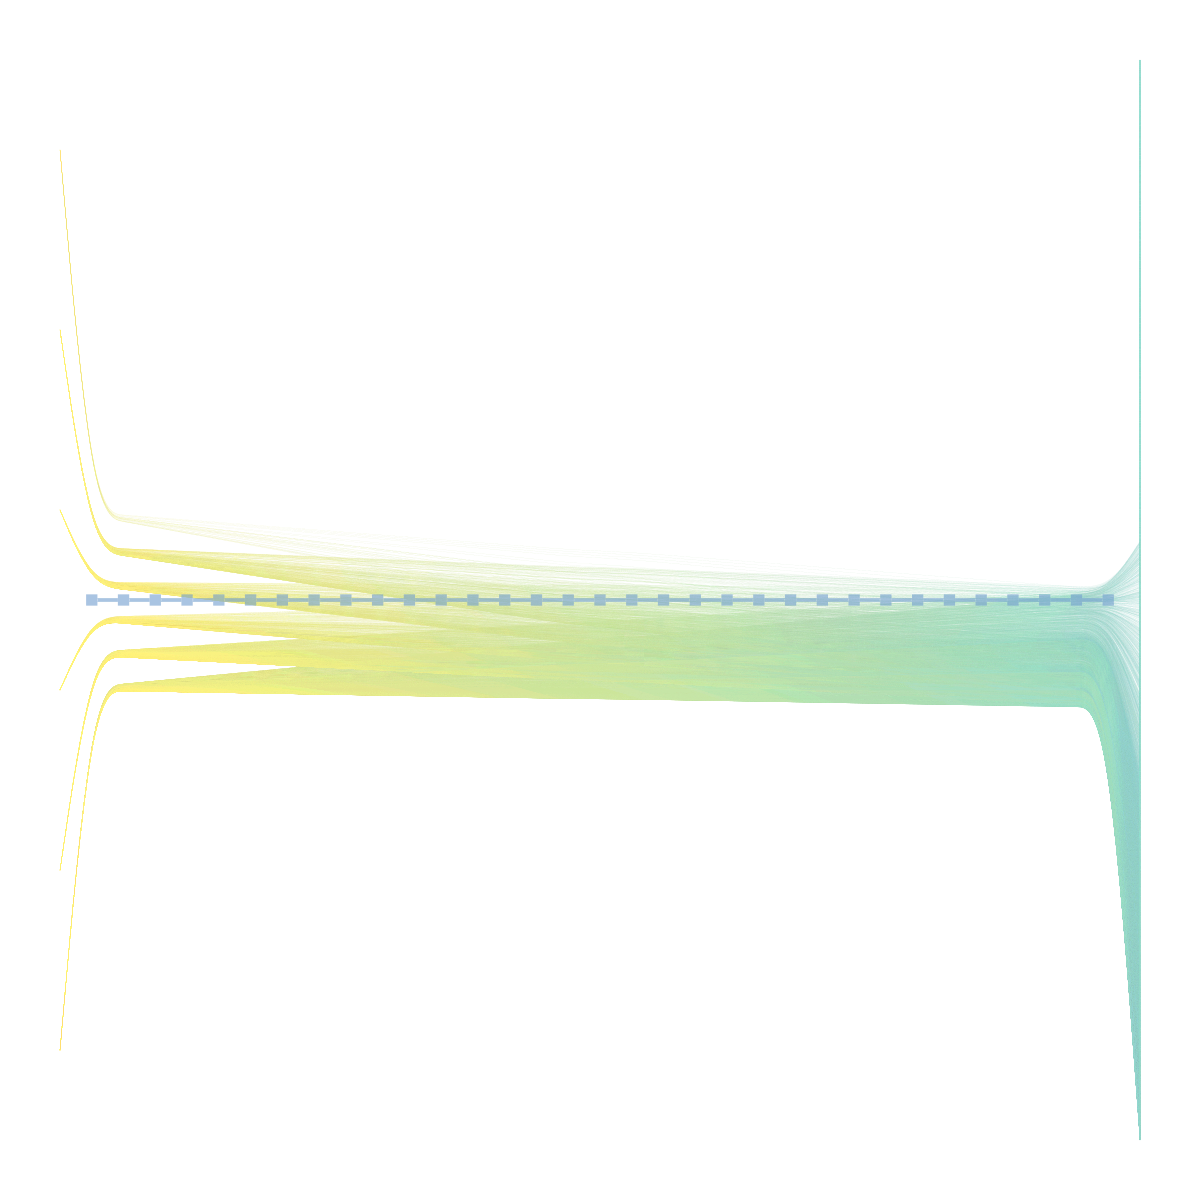

(<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7eff40562a60, at 0x7eff40767d60>,
 <GraphView object, directed, with 38456 vertices and 38455 edges, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x7eff40767b50, at 0x7eff4067c550>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x7eff40767b50, at 0x7eff4067c370>, False), at 0x7eff40767b50>,
 <VertexPropertyMap object with value type 'vector<double>', for Graph 0x7eff40767b50, at 0x7eff406ec6a0>)

In [12]:
new_state.draw(layout="bipartite",subsample_edges=6000,bip_aspect=1, hvertex_size=8, hedge_pen_width=1.9, output_size=(600, 600))

In [13]:
for i_n_init in range(10):
    base_type = gt.BlockState
    state_tmp = gt.minimize_nested_blockmodel_dl(graph,
                                                state_args=dict(
                                                    base_type=base_type,
                                                    **{'clabel': state_0.g.vp['kind'], 'pclabel': state_0.g.vp['kind']}),
                                                multilevel_mcmc_args=dict(
                                                    verbose=False))
    L = 0
    for s in state_tmp.levels:
        L += 1
        if s.get_nonempty_B() == 2:
            break
    state_tmp = state_tmp.copy(bs=state_tmp.get_bs()[:L] + [np.zeros(1)])

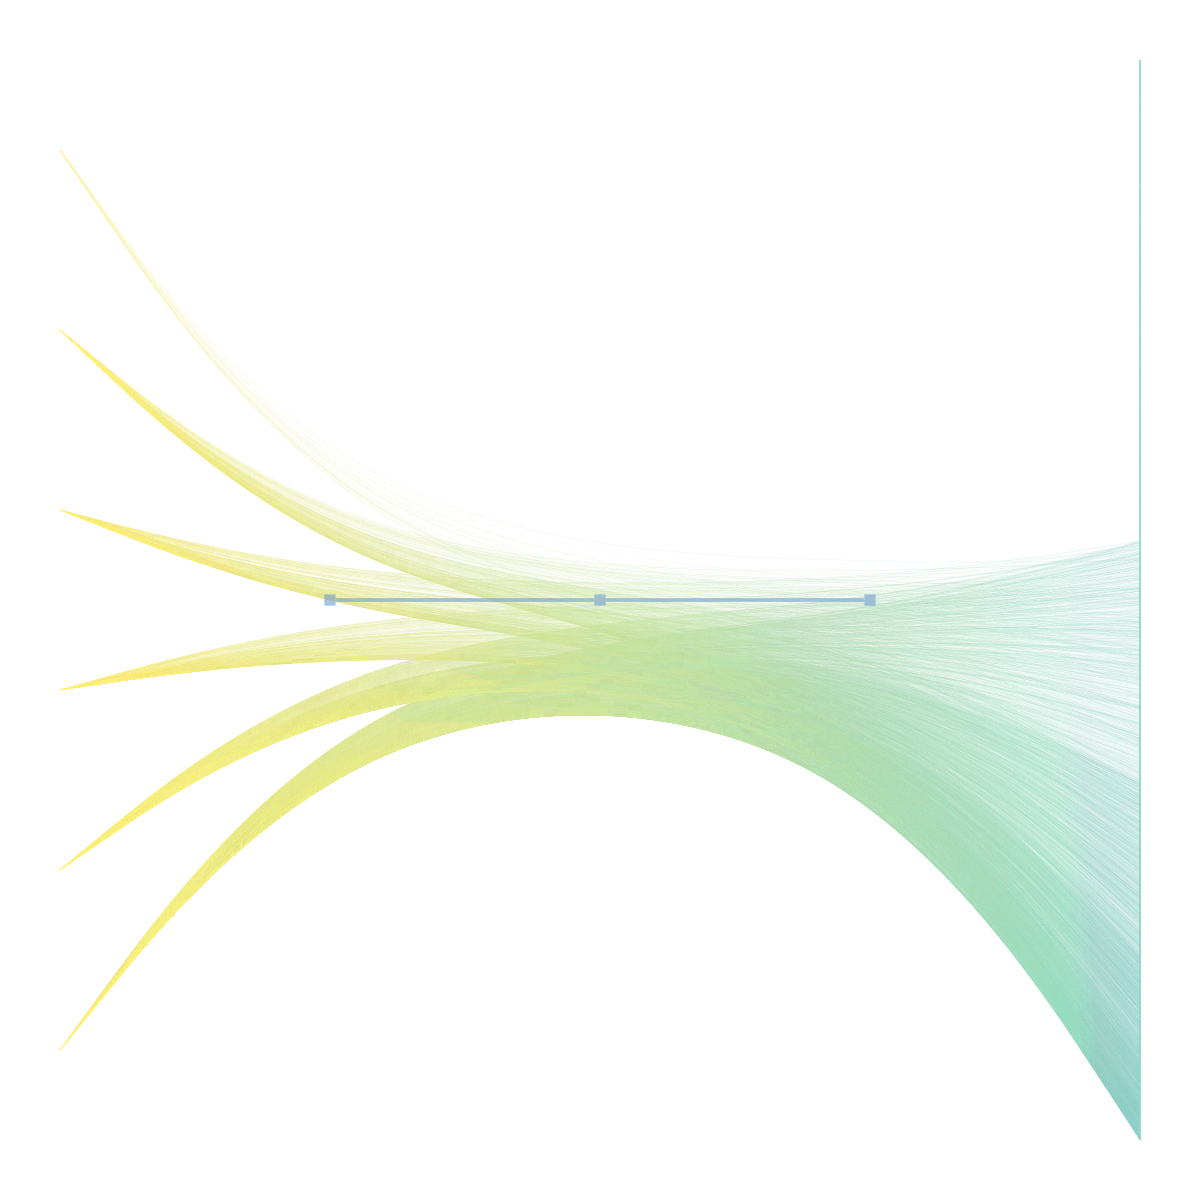

(<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7eff40562a60, at 0x7eff406aba30>,
 <GraphView object, directed, with 38426 vertices and 38425 edges, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x7eff406abca0, at 0x7eff09efce20>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x7eff406abca0, at 0x7eff09eb7dc0>, False), at 0x7eff406abca0>,
 <VertexPropertyMap object with value type 'vector<double>', for Graph 0x7eff406abca0, at 0x7eff09eb60d0>)

In [14]:
state_tmp.draw(layout="bipartite",subsample_edges=6000,bip_aspect=1, hvertex_size=8, hedge_pen_width=1.9, output_size=(600, 600))

In [15]:
features_index = index_array(which_model=state_tmp, clabel=1)
patients_index = index_array(which_model=state_tmp, clabel=0)

df = pd.DataFrame(data=0, index=patients_index, columns=features_index)

for patient in patients_index:
    neighbors = state_tmp.g.get_all_neighbors(patient)
    if neighbors.size == 0:
        continue
    else:
        for col in df.columns:
            if col in neighbors:
                df[col][patient] = 1

df

,38417,38418,38419,38420,38421,38422
0,0,0,0,0,1,0
1,0,1,0,0,1,0
2,0,0,0,1,0,0
3,0,1,0,1,0,0
4,0,0,0,0,0,0
...,...,...,...,...,...,...
38412,0,0,0,0,0,0
38413,0,1,0,1,0,0
38414,0,0,0,0,0,0
38415,0,0,0,0,1,0


In [16]:
df.describe()

,38417,38418,38419,38420,38421,38422
count,38417.000000,38417.000000,38417.000000,38417.00000,38417.000000,38417.000000
mean,0.109821,0.359685,0.084416,0.26228,0.101674,0.007757
std,0.312671,0.479914,0.278014,0.43988,0.302223,0.087733
min,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
75%,0.000000,1.000000,0.000000,1.00000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000


In [17]:
for v in model.state.g.vertices():
    if state.g.vp['kind'][v]==1:
        print('name: %s , index: %d' % (state.g.vp['name'][v], v))

name: renal_failure , index: 38417
name: hypertension , index: 38418
name: liver_disease , index: 38419
name: cardiac_arrhythmias , index: 38420
name: valvular_disease , index: 38421
name: peptic_ulcer , index: 38422


In [18]:
df = df.rename(columns={38417: "renal_failure", 38418: "hypertension", 38419: "liver_disease", 38420: "cardiac_arrhythmias", 
                   38421: "valvular_disease", 38422: "peptic_ulcer"})

In [19]:
df.to_csv("synthetic_simple_elixhauser_comorbidity.csv",index=False)

In [8]:
df_org = pd.read_csv("elixhauser_comorbidity_icd9_primary_secondary.csv", index_col=False)
df_org.describe()

TypeError: read_csv() got an unexpected keyword argument 'index'

In [23]:
print(gt.vertex_average(state.g, "total"))
print(gt.vertex_average(state_tmp.g, "total"))

(2.4038206282695262, 0.659118143072608)
(2.4026754808317934, 0.6584413842342788)


In [24]:
# edge overlap
overlap = 0
for e in state.g.edges():
    if state_tmp.g.edge(e.source(), e.target()):
        overlap += 1
overlap

18454

In [25]:
# similarity
gt.similarity(state.g, state_tmp.g)

0.399696772796188

In [26]:
df_org = df_org.rename(columns={38417: "renal_failure", 38418: "hypertension", 38419: "liver_disease", 38420: "cardiac_arrhythmias", 
                   38421: "valvular_disease", 38422: "peptic_ulcer"})

In [27]:
list(df_org)

['renal_failure',
 'hypertension',
 'liver_disease',
 'cardiac_arrhythmias',
 'valvular_disease',
 'peptic_ulcer']

In [28]:
# Hamming Distance
distance = []
for disease in list(df_org):
    d = np.sum(df_org[disease].to_list() != df[disease].to_list())
    distance.append(d)

# Calculate the average distance
distance = np.mean(distance)

# Print the result
print(f"Hamming distance: {distance:.2f}")

Hamming distance: 1.00


In [29]:
# Jaccard index
similarity = []
for disease in list(df_org):
    s = np.intersect1d(df_org[disease].to_list(), df[disease].to_list()).size / np.union1d(df_org[disease].to_list(),df[disease].to_list()).size
    similarity.append(s)

# Calculate the overall similarity
similarity = np.mean(similarity)

# Print the result
print(f"Jaccard similarity: {similarity:.2f}")

Jaccard similarity: 1.00


In [30]:
from sklearn.metrics import jaccard_score

similarity = []
for disease in list(df_org):
    s = jaccard_score(df_org[disease].to_list(), df[disease].to_list())
    similarity.append(s)


# Calculate the overall similarity
similarity = np.mean(similarity)

# Print the result
print(f"Jaccard similarity: {similarity:.2f}")


Jaccard similarity: 0.18


In [33]:
# Chi-squared test


In [34]:
import matplotlib.pyplot as plt 

list(df_org.columns)
df.sum(axis=0)

renal_failure           4085
hypertension           13846
liver_disease           3302
cardiac_arrhythmias    10078
valvular_disease        3806
peptic_ulcer             319
dtype: int64